In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
import sys
from threading import Thread
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
import pyvistaqt as pvqt

# pv.set_jupyter_backend('pythreejs')
# pv.set_jupyter_backend('ipygany') # ipygany fails " Failed to use notebook backend: "
# pv.set_jupyter_backend('panel') # Doesn't work either, produces no output
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors

import ipywidgets as widgets
# Imports PIL module
import PIL # For applying the binary mask as a image texture to a mesh
# import opencv
from IPython.display import display # For manual display customization


In [4]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data


In [5]:
mat_import_file = 'data/RoyMaze1/positionAnalysis.mat'
data = import_mat_file(mat_import_file=mat_import_file)

Loading matlab import file: data/RoyMaze1/positionAnalysis.mat...
done.


In [6]:
# data.keys()

t,x,y,speeds,dt,dx,dy = process_positionalAnalysis_data(data)
print('shapes - t: {}, x: {}, y: {}'.format(np.shape(t), np.shape(x), np.shape(y))) 
extrema_min, extrema_max = np.nanmin(x), np.nanmax(x)
print('for x: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))
extrema_min, extrema_max = np.nanmin(y), np.nanmax(y)
print('for y: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))
 

shapes - t: (324574,), x: (324574,), y: (324574,)
for x: extrema_min: 74.29166666666666, extrema_max: 649.3020833333334
for y: extrema_min: 160.54166666666666, extrema_max: 263.0


point_heatmap_value: [185.70297284 185.70297284 185.70297284 ... 171.79750638 171.79750638
 171.79750638]


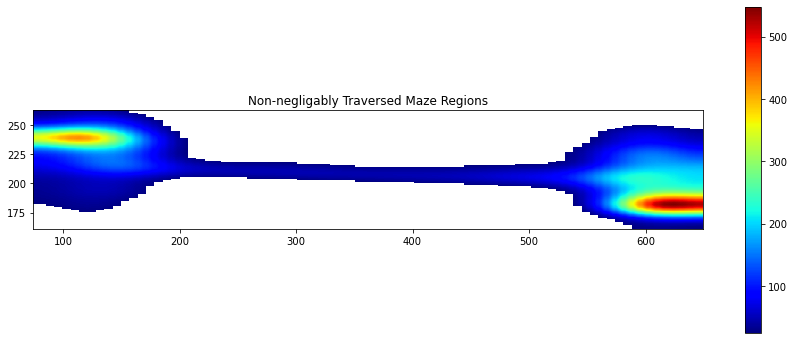

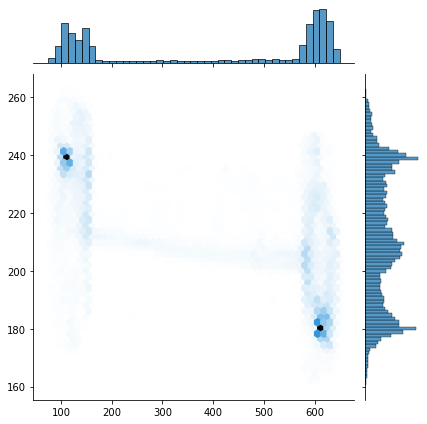

In [7]:
should_show_2d_plots = True

# Create a representation of the general maze layout by binning the data and then building a mask from all the points the animal ever traversed in the maze
# Output: negligably_traversed_maze_regions - an 80x80 binary mask that specifies which maze regions are never traversed.

# For the 1.6m track, we want bins of ~2cm -> 80 bins
num_position_bins = 80
# position_bins = np.linspace(0.0, 1.6, num_position_bins)
# digitized_x = np.digitize(x, position_bins)
# digitized_y = np.digitize(y, position_bins)

# smoothing_sigma = 2
smoothing_sigma = 4
img, extent, xedges, yedges = gen_2d_histrogram(x, y, smoothing_sigma)

def bin_edges_to_midpoints(x):
    # Takes a set of N+1 edges and gets the N midpoints centered between each pair
    # See https://stackoverflow.com/questions/23855976/middle-point-of-each-pair-of-an-numpy-array
    return (x[1:] + x[:-1]) / 2

xmidpoints = bin_edges_to_midpoints(xedges)
ymidpoints = bin_edges_to_midpoints(yedges)

## Get the histogram x that corresponds to each x, etc.
digitized_x = np.digitize(x, xedges)-1
digitized_y = np.digitize(y, yedges)-1

get_point_heatmap_value = lambda i, : img.T[(digitized_x[i]-1), (digitized_y[i]-1)]
point_heatmap_value = np.array(list(map(get_point_heatmap_value, range(0, len(digitized_x)))))

cmap,norm,point_colors = get_heatmap_color_vectors(point_heatmap_value)
print('point_heatmap_value: {}'.format(point_heatmap_value))

# print('img: {}'.format(np.shape(img)))
# img_mask = np.nonzero(img)
negligably_traversed_maze_regions = np.where(img < 25)
# print('negligably_traversed_maze_regions: {}'.format(np.shape(negligably_traversed_maze_regions)))
img_mask = img
img_mask[negligably_traversed_maze_regions] = np.nan


boosted_img = pow(img, 2)
# print('np.shape(img): {}, img: {}'.format(np.shape(img), img))

if should_show_2d_plots:
    fig, ax = plt.subplots(figsize=(15,6))
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    plt.colorbar()
    plt.title('Non-negligably Traversed Maze Regions')
    # xx, yy = np.meshgrid(position_bins, position_bins)
    # # xx, yy = np.meshgrid(digitized_x, digitized_y)
    # plt.imshow(z_values, cmap='hot', interpolation='nearest')
    # plt.hexbin(x, y, C=z_values, gridsize=gridsize, cmap=CM.jet, bins=None)
    # ax = sns.heatmap(z_values, linewidth=0.5)
    sns.jointplot(x=x, y=y, kind='hex')
    plt.show()

xedges: (81,), yedges: (81,), extent: (4,), img: (80, 80)



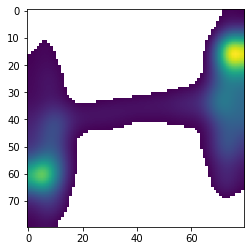

In [8]:
plt.imshow(img_mask)
print('xedges: {}, yedges: {}, extent: {}, img: {}\n'.format(np.shape(xedges), np.shape(yedges), np.shape(extent), np.shape(img)))
# print('xedges: {}, yedges: {}, extent: {}\n'.format(xedges, yedges, extent))
# plt.imshow(point_heatmap_value)
hist_grid_xx, hist_grid_yy = np.meshgrid(xmidpoints, ymidpoints)
hist_grid_zz = img

# Create and plot structured grid
occupancy_heatmap_grid = pv.StructuredGrid(hist_grid_xx, hist_grid_yy, hist_grid_zz)
occupancy_heatmap_grid.point_data['values'] = hist_grid_zz.flatten(order='F')
occupancy_heatmap_surface = occupancy_heatmap_grid.warp_by_scalar('values')
occupancy_heatmap_surface = occupancy_heatmap_surface.extract_surface()
occupancy_heatmap_surface.point_data['values'] = hist_grid_zz.flatten(order='F')
# mesh.plot()

origin = occupancy_heatmap_grid.center
origin[-1] -= occupancy_heatmap_grid.length / 3.0
occupancy_heatmap_floor_surface = occupancy_heatmap_surface.project_points_to_plane(origin=origin)
# occupancy_heatmap_floor_surface.plot(show_edges=True, show_grid=True, notebook=False)

# occupancy_heatmap_surface = pv.PolyData(occupancy_heatmap_grid)

# Apply an Elevation filter
# occupancy_heatmap_surface = occupancy_heatmap_grid.elevation()
# occupancy_heatmap_surface.plot(show_edges=True, show_grid=True, notebook=False)




# # occupancy_heatmap_grid.points = img
# p = pv.Plotter()
p = pvqt.BackgroundPlotter()
# p.background_color = 'black'
# origin = occupancy_heatmap_grid.center
# origin[-1] -= occupancy_heatmap_grid.length / 3.0
# projected = occupancy_heatmap_surface.project_points_to_plane(origin=origin)

# p.add_mesh(occupancy_heatmap_grid, show_edges=True)
# p.add_mesh(occupancy_heatmap_surface)
p.add_mesh(occupancy_heatmap_floor_surface)

# p.add_points(pdata)
# p.add_bounding_box()
# p.show_grid()
p.show()


In [9]:
# point_cloud = np.random.random((100, 3))
# z = point_heatmap_value
z = np.zeros_like(x)
point_cloud = np.vstack((x, y, z)).T
pdata = pv.PolyData(point_cloud)
pdata['orig_sphere'] = np.arange(np.shape(point_cloud)[0])

# create many spheres from the point cloud
sphere = pv.Sphere(radius=0.2, phi_resolution=3, theta_resolution=3)
pc = pdata.glyph(scale=False, geom=sphere)

In [ ]:
# pc.plot(cmap='Reds')
# pc.plot()

p = pv.Plotter()
p.background_color = 'black'
p.add_points(pdata)
p.add_bounding_box()
p.show_grid()
p.show()


In [ ]:
p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance
p.background_color = 'black'
p.add_points(pdata)
p.add_bounding_box()
p.show_grid()
p.show()


In [ ]:
# pc.plot(cmap='Reds', notebook=True, jupyter_backend='ipygany') # ipygany fails " Failed to use notebook backend: "

In [ ]:
pc.plot(cmap='Reds', notebook=True, jupyter_backend='panel')

In [ ]:
## Plot the raw position points

# pvmesh = examples.download_topo_global()
pvmesh = pv.examples.download_st_helens()

ugrid = pvmesh.cast_to_unstructured_grid()

# Turn the PyVista mesh into a PolyMesh
mesh = PolyMesh.from_vtk(ugrid)

colored_mesh = IsoColor(mesh, min=-10421.0, max=6527.0)
warped_mesh = WarpByScalar(colored_mesh, input='altitude', factor=0.5e-5)

Scene([warped_mesh])

In [ ]:
# Projected Maze 2D Outline:
maze_outline_x = x
maze_outline_y = y


In [12]:
# Split the position data into equal sized chunks to be displayed at a single time. These will look like portions of the trajectory and be used to animate. # Chunk the data to create the animation.
# curr_view_window_length = 150 # View 5 seconds at a time (30fps)
curr_view_window_length = 30 # View 5 seconds at a time (30fps)
# The original length 324574 / 30 = 10819
t_fixedSegements,x_fixedSegements,y_fixedSegements,speeds_fixedSegements,dt_fixedSegements,dx_fixedSegements,dy_fixedSegements = process_chunk_equal_poritions_data(t, x, y, speeds, dt, dx, dy, curr_view_window_length)
print('shapes - t_fixedSegements: {}, x_fixedSegements: {}, y_fixedSegements: {}'.format(np.shape(t_fixedSegements), np.shape(x_fixedSegements), np.shape(y_fixedSegements)))
z_fixedSegements = np.zeros_like(x_fixedSegements)


shapes - t_fixedSegements: (10819, 30), x_fixedSegements: (10819, 30), y_fixedSegements: (10819, 30)


In [38]:
# Plot current segment as spline:
def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points)-1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points)-1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly

num_time_points = np.shape(x_fixedSegements)[0]
print('num_time_points: {}\n'.format(num_time_points))
animal_location_sphere = pv.Sphere(radius=2.3)
animal_location_direction_cone = pv.Cone()

#     animal_direction_arrow = pv.Arrow()
last_only_opacity_values = np.zeros([curr_view_window_length,])
last_only_opacity_values[-1] = 1.0

# last_only_opacity_values = np.zeros([1,curr_view_window_length])
# last_only_opacity_values[-1] = 1.0

active_trail_opacity_values = last_only_opacity_values.copy()
print('active_trail_opacity_values: {}\n'.format(np.shape(active_trail_opacity_values)))
    
## Slider with Callback Function Example:

# p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance

def on_slider_update_mesh(value):
    curr_i = int(value)
    # point_cloud_fixedSegements = np.vstack((x_fixedSegements, y_fixedSegements, z_fixedSegements)).T
    point_cloud_fixedSegements = np.column_stack((x_fixedSegements[curr_i,:], y_fixedSegements[curr_i,:], z_fixedSegements[curr_i,:]))
#     print('point_cloud_fixedSegements: {}\n'.format(np.shape(point_cloud_fixedSegements)))
    curr_animal_point = point_cloud_fixedSegements[-1,:] # Get the last point
#     actor = p.add_mesh(pyvista.Cube(), show_edges=True)
#     mesh = pv.PolyData(point_cloud_fixedSegements)
#     mesh.plot(point_size=10, style='points')
    pdata = pv.PolyData(point_cloud_fixedSegements) # a mesh
#     pdata['orig_sphere'] = np.arange(np.shape(point_cloud)[0])
    
#     print(last_only_opacity_values)
    
#     pdata.point_data['pho_fade_values'] = np.arange(np.shape(point_cloud_fixedSegements)[0])
    pdata.point_data['pho_fade_values'] = active_trail_opacity_values

    # create many spheres from the point cloud
    pc = pdata.glyph(scale=False, geom=animal_location_sphere)
    # pc.point_data['pho_fade_values'] = active_trail_opacity_values
        
    # plines = p.add_lines(point_cloud_fixedSegements, name='animal_trajectory_lines', color='orange')
    # plines.point_data['pho_fade_values'] = active_trail_opacity_values
    #     p.add_mesh(pc, name='animal_location', color="red", opacity='linear', scalars='pho_fade_values', nan_opacity=0.0)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity=0.8, nan_opacity=0.0)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity="pho_fade_values", nan_opacity=0.0)

    p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity=0.8, nan_opacity=0.0, render_lines_as_tubes=True)
#     p.add_mesh(animal_location_sphere, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
    
#     # Create spline with 1000 interpolation points
#     spline = pv.Spline(point_cloud_fixedSegements)
# #     # add scalars to spline and plot it
#     spline["scalars"] = np.arange(spline.n_points)
#     tube = spline.tube(radius=0.1)
# #     tube.plot(smooth_shading=True)
#     p.add_mesh(tube, name='tube')

#     sphere = pv.Sphere(phi_resolution=res, theta_resolution=res)
#     p.add_mesh(sphere, name='sphere', show_edges=True)
    return

## Save out to MP4 Movie
def make_mp4_from_plotter(active_plotter, active_frame_range, update_callback, filename='sphere-shrinking.mp4'):
    # Open a movie file
    print('active_frame_range: {}'.format(active_frame_range))
    try:
        # Further file processing goes here
        print('Trying to open mp4 movie file at {}...\n'.format(filename))
        active_plotter.open_movie(filename)
        active_plotter.show(auto_close=False)  # only necessary for an off-screen movie
        # Run through each frame
        active_plotter.write_frame()  # write initial data
        total_number_frames = np.size(active_frame_range)
        print('\t opened. Planning to write {} frames...\n'.format(total_number_frames))
        # Update scalars on each frame
        for i in active_frame_range:
            print('\t Frame[{} of {}]\n'.format(i, total_number_frames))
            # Call the provided update_callback function:
            update_callback(i)
            active_plotter.add_text(f"Iteration: {i}", name='time-label')
            active_plotter.write_frame()  # Write this frame

    finally:
        # Be sure to close the plotter when finished
        active_plotter.close()
        print('File reader closed!')
        
    print('done.')
    

        
# p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance
p = pv.Plotter() # Use just like you would a pv.Plotter() instance
# p.background_color = 'black'
p.add_points(pdata)
# p.add_slider_widget(on_slider_update_mesh, [0, (num_time_points-1)], title='Trajectory Timestep', event_type='always', style='modern')

# active_frame_range = np.arange(num_time_points) # All frames
active_frame_range = np.arange(100) # Only 100 frames
# active_frame_range = range(100) # Only 100 frames                  
make_mp4_from_plotter(p, active_frame_range, on_slider_update_mesh, filename='test_plotting.mp4')

# p.add_bounding_box()
# p.show_grid()
# p.add_axes(line_width=5, labels_off=True)
# p.hide_axes()
# p.show()
                
                  
print('all done!')

num_time_points: 10819

active_trail_opacity_values: (30,)

active_frame_range: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Trying to open mp4 movie file at test_plotting.mp4...



ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

	 opened. Planning to write 100 frames...

	 Frame[0 of 100]

	 Frame[1 of 100]

	 Frame[2 of 100]

	 Frame[3 of 100]

	 Frame[4 of 100]

	 Frame[5 of 100]

	 Frame[6 of 100]

	 Frame[7 of 100]

	 Frame[8 of 100]

	 Frame[9 of 100]

	 Frame[10 of 100]

	 Frame[11 of 100]

	 Frame[12 of 100]

	 Frame[13 of 100]

	 Frame[14 of 100]

	 Frame[15 of 100]

	 Frame[16 of 100]

	 Frame[17 of 100]

	 Frame[18 of 100]

	 Frame[19 of 100]

	 Frame[20 of 100]

	 Frame[21 of 100]

	 Frame[22 of 100]

	 Frame[23 of 100]

	 Frame[24 of 100]

	 Frame[25 of 100]

	 Frame[26 of 100]

	 Frame[27 of 100]

	 Frame[28 of 100]

	 Frame[29 of 100]

	 Frame[30 of 100]

	 Frame[31 of 100]

	 Frame[32 of 100]

	 Frame[33 of 100]

	 Frame[34 of 100]

	 Frame[35 of 100]

	 Frame[36 of 100]

	 Frame[37 of 100]

	 Frame[38 of 100]

	 Frame[39 of 100]

	 Frame[40 of 100]

	 Frame[41 of 100]

	 Frame[42 of 100]

	 Frame[43 of 100]

	 Frame[44 of 100]

	 Frame[45 of 100]

	 Frame[46 of 100]

	 Frame[47 of 100]

	 Frame

In [ ]:
# scales = {
#     'x': bqplot.scales.LinearScale(min=10**-3, max=10**3),
#     'y': bqplot.scales.LinearScale(min=-3, max=3),
#     'z': bqplot.scales.LinearScale(min=-3, max=3),
# }
# color_scale = bqplot.scales.ColorScale(min=0, max=3, colors=["#f00", "#0f0", "#00f"])

In [ ]:
x, y, z, u, v, w = np.random.random((6, 1000))*2-1
selected = np.random.randint(0, 1000, 100)
ipv.figure()
quiver = ipv.quiver(x, y, z, u, v, w, size=5, size_selected=8, selected=selected)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((quiver, 'size'), (size, 'value'))
jslink((quiver, 'size_selected'), (size_selected, 'value'))
jslink((quiver, 'color'), (color, 'value'))
jslink((quiver, 'color_selected'), (color_selected, 'value'))
VBox([ipv.gcc(), size, size_selected, color, color_selected])